## Spotify Billboard 200 Second Impression

Refer to `bb200_first_impressions.ipynb` for the initial run-through and analysis of the features. In this notebook, we will quickly prepare the data for modeling in the same way we did in the first notebook, but perform some feature selection on our data. In the first notebook, we successfully fit a single decision tree with 75% cross-validated and out of sample accuracies; we will reuse its parameters during our feature selection process, try some over-under sampling, and then proceed to use AdaBoost to see if we can get additional predictive power through additive classifying trees.

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
sns.set()
%matplotlib inline

### Data preprocessing

As in `bb200_first_impressions.ipynb`, we first preprocess our data to deal with the missing values and standardize our continuous features.

**Remark.** Refer to `bb200_first_impressions.ipynb` for why exactly the code is as it is below.

In [124]:
# raw data
af_raw = pd.read_csv("./data/acoustic_features.csv")
# amend missing data
af_raw.iloc[241999, 3] = "Kenny G"
af_raw.loc[pd.isna(af_raw["artist"]), af_raw.columns == "artist"] = "Various Artists"
# create X and y; note that y is categorical now
X = af_raw.loc[:, af_raw.columns != "danceability"].dropna().copy()
y = pd.DataFrame(map(lambda x : 1 if x > 0.5 else 0, af_raw["danceability"].dropna()),
                columns = ["danceable"], index = X.index)
# standardize continuous features (we might want to run other models later)
cont_cols = ["acousticness", "duration_ms", "energy", "instrumentalness", "liveness", 
             "loudness", "speechiness", "tempo", "valence"]
# scale continuous columns and make new DataFrame out of them
sscl = StandardScaler()
Xs_cont = pd.DataFrame(sscl.fit_transform(X[cont_cols]), columns = cont_cols)
# get dummies for key and time_signature (mode is already 1 for major, 0 for minor)
# we ignore mode since mode is 1 for major, 0 for minor
cat_cols = ["key", "time_signature"]
# get dummies for each of the columns; need to map to string to be treated as categorical
X_cat = None
for cc in cat_cols:
    ccat = pd.get_dummies(pd.DataFrame(map(lambda x: str(int(x)), X[cc]), columns = [cc]), 
                          prefix = cc[:3])
    if X_cat is None: X_cat = ccat
    else: X_cat = X_cat.merge(ccat, how = "outer", left_index = True, right_index = True)
# merge standardized continuous features with categorical features
X = Xs_cont.merge(X_cat, how = "outer", left_index = True, right_index = True)
# check shapes of X, y
print("X shape: {0}\ty shape: {1}".format(X.shape, y.shape))
# preview X
X.head()

X shape: (339850, 26)	y shape: (339850, 1)


,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_5,key_6,key_7,key_8,key_9,tim_0,tim_1,tim_3,tim_4,tim_5
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590,0,...,0,1,0,0,0,0,0,0,1,0
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669,0,...,0,1,0,0,0,0,0,0,1,0


Now we are ready to do some cross-validated feature selection using the same decision tree we tuned in `bb200_fist_impressions.ipynb`.

### CV feature selection: decision tree

We tuned the decision tree already, so we will use the same hyperparameters and instead focus on selecting features. As usual, we do an 80-20 training and test split, and cross-validate on the training portion to select our features before reporting test performance. Again, we choose accuracy as the criterion, and perform 5-fold cross-validation on our training data during our feature selection.

**Remark.** The entire feature selection process takes around ~3 minutes on my machine, using 2 cores. Results may vary.

In [125]:
# create tuned decision tree and RFECV objects with 5-fold CV
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 25, max_features = "auto",
                             min_samples_split = 40)
dtc_rfecv = RFECV(dtc, cv = 5, scoring = "accuracy", verbose = 1, n_jobs = 2)
# 80/20 train test split and feature selection on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
dtc_rfecv.fit(X_train, y_train)

c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFECV(cv=5,
      estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                       max_depth=25, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=40,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=None,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

Now that we have pruned our feature matrix, let's see which features were selected during feature elimination, and how many of them we have.

In [128]:
sfdf = X.columns[dtc_rfecv.support_]
print("{0}\n{1} selected features".format(sfdf, len(sfdf)))

Index(['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'tim_4'],
      dtype='object')
10 selected features


We have thus gone from 26 features to 10 features. Interestingly, most of our categorical features have been dropped. Let us check our cross-validated training and our holdout test accuracies to see if there is any meaningful difference between the two.

In [153]:
print("train accuracy:\t{0:.5f}\ntest accuracy:\t{1:.5f}".format(dtc_rfecv.score(X_train, y_train), 
                                                                 dtc_rfecv.score(X_test, y_test)))

train accuracy:	0.84623
test accuracy:	0.75526


Hm, it looks like our tree has overfit a lot more than we have liked it to, as we have nearly a 10% decrease in accuracy on the test data. However, this test accuracy is still about the same as what we had for our decision tree in `bb200_first_impressions.ipynb`, and using far fewer features.

### Over-under sampling: decision tree

In a previous semester, my BAC group had shown that using the `imblearn` method `SMOTEENN`, a combination of using the SMOTE (Synthetic Minority Oversampling TEchnique) algorithm with edited nearest neighbors, improved the accuracy of a decision tree trained on a multi-class data set with unbalanced class proportions. We will apply `SMOTEENN` to our training data to equalize the unbalanced class proportions, which are shown in the graph below.

**Remark.** We apply `SMOTEENN` only to our **training** data because we want the test data to represent unbalanced reality.

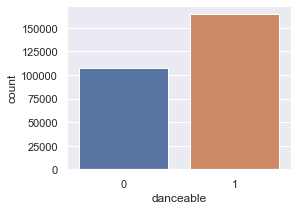

In [177]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(y_train["danceable"], ax = ax)

However, only `SMOTENC`, a vanilla SMOTE implementation for both categorical and continuous data, can be used given the presence of categorical features. But as was revealed from recursive feature elimination, only one of the categorical features, `tim_4`, which indicates that a song has 4 beats per measure, was included among our 10 selected features. Let's drop that feature to create our reduced feature matrix `Xr`.

In [178]:
Xr = X[sfdf[:-1]].copy()
Xr.head()

,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669


We perform the usual 80/20 `train_test_split` to get our training and test partitions, using the same value for `random_state` to make the same data partition. `SMOTE` will give us a modified `Xr_train` which we will call `Xm_train` and a modified `yr_train` which we will call `ym_train`.

**Remark.** This cell took around 3 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [183]:
# use same random state to get the same split of our training and test data
Xr_train, Xm_test, yr_train, ym_test = train_test_split(Xr, y, test_size = 0.2, random_state = 5)
# use constant seed for test purposes and balance classes equally. [try] to run on 
# two threads (not guaranteed) as multithreading not necessarily possible due to 
# python's (notorious?) global interpreter lock
sme = SMOTEENN(random_state = 11, n_jobs = 2)
# check shape pre-resample
print("Xr_train shape: {0}\tyr_train shape: {1}".format(Xr_train.shape, yr_train.shape))
# resample to equally balance classes; put ym_train back in DataFrame
Xm_train, ym_train = sme.fit_resample(Xr_train, yr_train)
ym_train = pd.DataFrame(ym_train, columns = ["danceable"])
# check shape post-resample
print("Xm_train shape: {0}\tym_train shape: {1}".format(Xm_train.shape, ym_train.shape))

Xr_train shape: (271880, 9)	yr_train shape: (271880, 1)


c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Xm_train shape: (188729, 9)	ym_train shape: (188729, 1)


We quickly check the class frequencies in our new modified response vector `ym_train`.

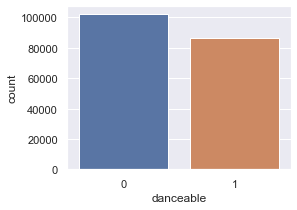

In [184]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(ym_train["danceable"], ax = ax)

We now perform a 5-fold cross-validated grid search using `GridSearchCV` to tune the parameters of our single decision tree to see how `SMOTEENN` may affect our training and test results. Again, we use accuracy as the scoring statistic for the grid search.

**Remark.** This cell took around 9 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [185]:
# new decision tree classifier; again use entropy
dtc = DecisionTreeClassifier(criterion = "entropy")
# same parameter grid as in bb200_first_impressions.ipynb but with some added values
param_grid = {"min_samples_split": [2, 10, 20, 40, 50], 
              "max_depth": [20, 25, 50, None], 
              "max_features": ["auto", None]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
dtc_gscv = GridSearchCV(dtc, param_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
dtc_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': [20, 25, 50, None],
                         'max_features': ['auto', None],
                     

As usual, we check the average cross-validated training score (accuracy) and the test score of the best fitted tree.

In [187]:
# our best decision tree estimator
dtc_best = dtc_gscv.best_estimator_
print("5-fold CV grid accuracy:\t{0:.5f}\nbest tree grid accuracy:\t{1:.5f}\n"
      "best tree test accuracy:\t{2:.5f}"
      "".format(dtc_gscv.cv_results_["mean_test_score"].mean(), dtc_gscv.best_score_, 
                dtc_best.score(Xm_test, ym_test)))
# show our best decision tree estimator
dtc_best

5-fold CV grid accuracy:	0.91638
best tree grid accuracy:	0.92247
best tree test accuracy:	0.75224


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Looks like 75% test accuracy is about as far as we can go. We see that `SMOTEENN` leads to the model significantly overfitting on the training data without resulting in much improvement in the test data at all. Although it is disappointing that such a powerful technique is not helping our out-of-sample performance, it matches the intuition we had in `bb200_first_impressions.ipynb`, which was that none of the categorical and only a couple of the continuous features seemed to have much meaningful variation with our response column `danceability`. We show our (high) misclassification rates below.

In [188]:
# our confusion matrix
cmat = confusion_matrix(ym_test, dtc_best.predict(Xm_test))
print("misclassification rate for 0: {0:.5f}\nmisclassification rate for 1: {1:.5f}"
      "".format(cmat[0][1] / sum(cmat[0]), cmat[1][0] / sum(cmat[1])))

misclassification rate for 0: 0.21644
misclassification rate for 1: 0.26832


To show some additional metrics, we show the model's precision, compute its AUC, and visualize the confusion matrix with its ROC curve.

best tree test precision:	0.83732
best tree test AUC:		0.75762


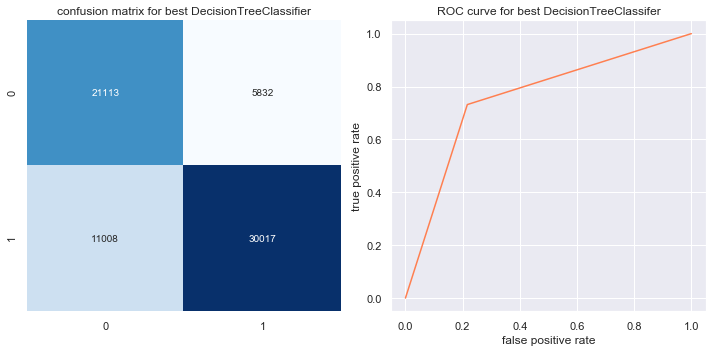

In [189]:
# predicted values from test feature matrix
ym_test_pred = dtc_best.predict(Xm_test)
print("best tree test precision:\t{0:.5f}\nbest tree test AUC:\t\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axs[0].set_title("confusion matrix for best DecisionTreeClassifier")
sns.heatmap(cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best DecisionTreeClassifer")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

The ROC curve can definitely use some work, and our misclassification rates are quite high. In the next section, we will move to try and increase our accuracy just a little bit more by using AdaBoost to create an additive model out of individual trees, in an effort to try and increase accuracy by just a little bit more.

### Boosting with AdaBoost: tree stumps

Before we consider training AdaBoost with our tuned decision tree, we will first establish a baseline for performance by using AdaBoost on decision tree stumps, i.e. trees that have `max_depth = 1`, the default base estimator used by the `AdaBoostClassifier`. We perform a 5-fold cross-validated grid search on resampled `Xm` and `ym`, varying the learning rate and the number of estimators to train unless an early stoppage is achieved.

**Remark.** We will use the default algorithm SAMME.R, as it is considered superior to SAMME.

**Remark.** We continue to use the same resampled `Xm_train` and `ym_train` data for convenience purposes.

**Remark.** This takes a longer time because we are fitting multiple sequences of tree stumps. With `n_jobs = 2`, it takes about 10 minutes on my machine.

In [190]:
# default base estimator is DecisionTreeClassifier(max_depth = 1), a stump
ada_stump = AdaBoostClassifier()
ada_stump_grid = {"n_estimators": [10, 20, 40, 50, 80], 
            "learning_rate": [0.01, 0.1, 1, 1.5]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_stump_gscv = GridSearchCV(ada_stump, ada_stump_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_stump_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  9.0min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.1, 1, 1.5],
                         'n_estimators': [10, 20, 40, 50, 80]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

As usual, we check the average cross-validated training score (accuracy) and the test score of the best boosted tree stump classifier.

In [193]:
# our best boosted tree stump classifer
ada_stump_best = ada_stump_gscv.best_estimator_
print("5-fold CV stump grid accuracy:\t{0:.5f}\nbest ada stump grid accuracy:\t{1:.5f}\n"
      "best ada stump test accuracy:\t{2:.5f}"
      "".format(ada_stump_gscv.cv_results_["mean_test_score"].mean(), ada_stump_gscv.best_score_, 
                ada_stump_best.score(Xm_test, ym_test)))
# show our best boosted tree stump estimator
ada_stump_best

5-fold CV stump grid accuracy:	0.86746
best ada stump grid accuracy:	0.91566
best ada stump test accuracy:	0.75670


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=80, random_state=None)

Our boosted stumps are clearly overfitting quite severely, with over an 86% average CV accuracy dropping to 75% on the test data. Thus, they provide about the same level of accuracy as a single decision tree while being more complex and much costlier to train.

Let us look at a few metrics. We show the precision, AUC, misclassification rates, and the ROC curve for our 80 boosted stumps.

misclassification rate for 0:	0.17302
misclassification rate for 1:	0.28946
best ada stump test precision:	0.86212
best ada stump test AUC:	0.76876


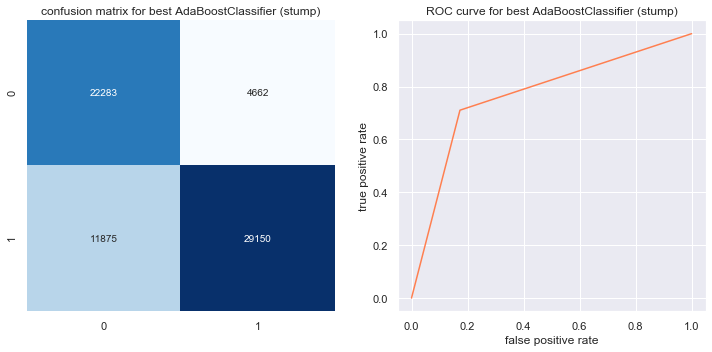

In [194]:
# our confusion matrix
ada_cmat = confusion_matrix(ym_test, ada_stump_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(ada_cmat[0][1] / sum(ada_cmat[0]), ada_cmat[1][0] / sum(ada_cmat[1])))
# predicted values from test feature matrix
ym_test_pred = ada_stump_best.predict(Xm_test)
print("best ada stump test precision:\t{0:.5f}\nbest ada stump test AUC:\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (stump)")
sns.heatmap(ada_cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (stump)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

The stumps are doing something interesting--they have reduced the misclassification rate for class 0 at the cost of class 1 being misclassified more often. We also see that the boosted stumps give a higher precision and slightly better AUC than the single decision tree.

We now move on to created a boosted classifier using tuned decision trees, hoping for the best.

### Boosting with AdaBoost: tuned decision tree

In [195]:
dtc_tuned = DecisionTreeClassifier(criterion = "entropy", max_depth = 20)
dtc_tuned

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

**Remark.** Now that we are fitting more complex trees, the amount of time this takes is definitely nontrivial. On my machine, with `n_jobs = 2`, I am at around 35 minutes. As usual, results may vary. Sadly longer model runtime doesn't always translate into a more accurate model.

In [197]:
# use the tuned decision tree as the base estimator
ada_tuned = AdaBoostClassifier(base_estimator = dtc_tuned)
# since each tree is pretty solid on its own, vary only number of trees
ada_tuned_grid = {"n_estimators": [10, 20, 40, 50]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_tuned_gscv = GridSearchCV(ada_tuned, ada_tuned_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_tuned_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 35.0min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=20,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                               

As usual, we check the average cross-validated training score (accuracy) and the test score of the best boosted tree classifier.

In [198]:
# our best boosted tuned tree classifer
ada_tuned_best = ada_tuned_gscv.best_estimator_
print("5-fold CV tuned grid accuracy:\t{0:.5f}\nbest ada tuned grid accuracy:\t{1:.5f}\n"
      "best ada tuned test accuracy:\t{2:.5f}"
      "".format(ada_tuned_gscv.cv_results_["mean_test_score"].mean(), ada_tuned_gscv.best_score_, 
                ada_tuned_best.score(Xm_test, ym_test)))
# show our best boosted tree estimator
ada_tuned_best

5-fold CV tuned grid accuracy:	0.95071
best ada tuned grid accuracy:	0.95544
best ada tuned test accuracy:	0.77771


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                         

We trained a model for almost 40 minutes, and are only at 77% test accuracy. One can see the massive overfitting; on the training data, our accuracy is 95%. It is reasonable to think that without seriously devoting time to "creative" feature engineering, this is best we can do. For comparison with the single tree and boosted stumps, we show the misclassification rates, precision, AUC, and ROC curve of the boosted trees.

**Remark.** We also notice that with the boosted stumps, grid search continues to choose the additive model with the largest number of trees. The potential for boosted trees to overfit is quite terrifying, and suggests that using models that underfit more provides more marginal predictive power when boosting.

misclassification rate for 0:	0.19391
misclassification rate for 1:	0.24093
best ada tuned test precision:	0.85632
best ada tuned test AUC:	0.78258


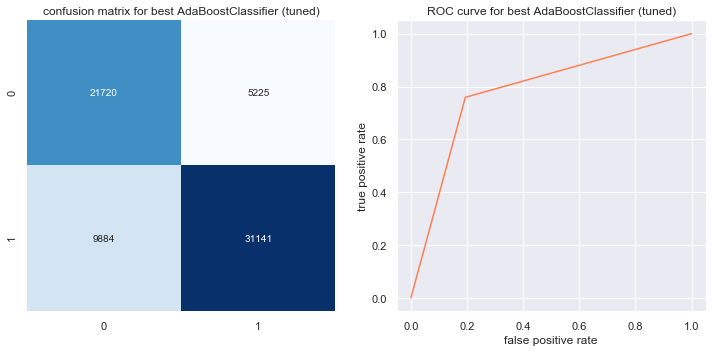

In [199]:
# our confusion matrix
adat_cmat = confusion_matrix(ym_test, ada_tuned_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(adat_cmat[0][1] / sum(adat_cmat[0]), adat_cmat[1][0] / sum(adat_cmat[1])))
# predicted values from test feature matrix
ym_test_pred = ada_tuned_best.predict(Xm_test)
print("best ada tuned test precision:\t{0:.5f}\nbest ada tuned test AUC:\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (tuned)")
sns.heatmap(adat_cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (tuned)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
fig.tight_layout()

Our misclassification rates are a little more balanced this time, but of course still high. Interestingly, the boosted trees have slightly less precision than the boosted stumps, but do have a slightly higher AUC and better ROC curve than both the boosted stumps and the single decision tree. However, it really does seem that without increasing the number of trees in our additive model, our accuracy is more or less bounded above by 80%.

We try one more thing to see if tree boosting can still be profitable, at the cost of complexity.

### Boosting with AdaBoost: increasing `n_estimators`

Since we have had some marginal return by using a more complex base estimator, and we see that if given multiple values for the maximum number of trees that may be trained, grid search continues to prefer training as many trees as possible. Let's go wild, one last time.

**Remark.** Be patient with this one. On my machine, with `n_jobs = 2`, it takes around xy minutes. Oof.

In [ ]:
# extended AdaBoostClassifier
ada_ext = AdaBoostClassifier(base_estimator = dtc_tuned)
# focus on training the maximum number of trees possible
ada_ext_grid = {"n_estimators": [100, 150]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_ext_gscv = GridSearchCV(ada_ext, ada_ext_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_ext_gscv.fit(Xm_train, ym_train)

As usual, we check the average cross-validated training score (accuracy) and the test score of the best extended boosted tree classifier.

In [ ]:
# our best boosted extended tree classifer
ada_ext_best = ada_ext_gscv.best_estimator_
print("5-fold CV ext grid accuracy:\t{0:.5f}\nbest ada ext grid accuracy:\t{1:.5f}\n"
      "best ada ext test accuracy:\t{2:.5f}"
      "".format(ada_ext_gscv.cv_results_["mean_test_score"].mean(), ada_ext_gscv.best_score_, 
                ada_ext_best.score(Xm_test, ym_test)))
# show our best extended boosted tree estimator
ada_ext_best